# Training and Evaluating a Keypoint Detection Model using ResNet50

In [2]:
!pip install PyDrive2

In [3]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive2 client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [3]:
file_id = '1lhAaeQCmk2y440PmagA0KmIVBIysVMwu'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data.zip')

In [4]:
import zipfile
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [4]:
# %%capture
# !unzip tennis_court_det_dataset.zip
# !rm -rf data.zip
# print('DONE')

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
import json
import cv2
import numpy as np
import os

import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available else 'cpu')

In [6]:
class KeypointsDataset(Dataset):
    def __init__(self, image_dir, data_file):
        self.image_dir = image_dir
        with open(data_file, 'r') as f:
            self.data = json.load(f)

        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        image = cv2.imread(f'{self.image_dir}/{item["id"]}.png')
        height, width = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image)
        keypoints = np.array(item['kps']).flatten()
        keypoints = keypoints.astype(np.float32)

        keypoints[::2] *= (224.0 / width)
        keypoints[1::2] *= (224.0 / height)

        return image, keypoints

In [7]:
HOME = os.getcwd()
img_dir = f'{HOME}/data/images'
train_annotation_dir = f'{HOME}/data/data_train.json'
validation_annotation_dir = f'{HOME}/data/data_val.json'

In [8]:
train_data = KeypointsDataset(img_dir, train_annotation_dir)
validation_data = KeypointsDataset(img_dir, validation_annotation_dir)


## Split data

In [9]:
test_split = 0.1
test_size = int(test_split * len(train_data))
train_size = len(train_data) - test_size

In [10]:
train_data, test_data = random_split(train_data, [train_size, test_size])

## Load pytorch data

In [11]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=8)
test_loader = DataLoader(test_data, batch_size=8)

# Load pretrained model

In [12]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(model.fc.in_features, 28)

In [13]:
model = model.to(device)

### Training setup

In [14]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [17]:
def train(
        _model,
        _criterion,
        _train_loader,
        _val_loader,
        _optimizer,
        _epochs,
        _device
):
    model_history = {
        'training_loss': [],
        'validation_loss': []
        }

    for epoch in range(_epochs):
        _model.train()
        train_loss = 0.0

        for imgs, kps in _train_loader:
            imgs = imgs.to(_device)
            kps = kps.to(_device)

            optimizer.zero_grad()
            pred_kps = _model(imgs)

            loss = criterion(pred_kps, kps)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model_history['training_loss'].append(train_loss / len(_train_loader))

        # Model validation
        _model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for imgs, kps in _val_loader:
                imgs = imgs.to(_device)
                kps = kps.to(_device)

                # Make prediction
                pred_kps = _model(imgs)
                loss = _criterion(pred_kps, kps)
                val_loss += loss.item()

        model_history['validation_loss'].append(val_loss / len(_val_loader))

        print(f'Epoch [{epoch+1}/{_epochs}], Training Loss: {model_history["training_loss"][-1]}, Validation Loss: {model_history["validation_loss"][-1]}')

    return model_history

In [18]:
# Training the model
epochs = 20
model_history = train(model, criterion, train_loader, val_loader, optimizer, epochs, device)

Epoch [1/20], Training Loss: 117.05556093527868, Validation Loss: 66.9146648365668
Epoch [2/20], Training Loss: 45.80772904736107, Validation Loss: 49.993706300370526
Epoch [3/20], Training Loss: 35.914844810802876, Validation Loss: 30.650900480979615
Epoch [4/20], Training Loss: 24.136419723564433, Validation Loss: 27.318372607661498
Epoch [5/20], Training Loss: 17.065959881521742, Validation Loss: 11.881153787086156
Epoch [6/20], Training Loss: 12.535254594707617, Validation Loss: 8.876071483004395
Epoch [7/20], Training Loss: 11.390423108042086, Validation Loss: 9.368233795845981
Epoch [8/20], Training Loss: 10.465260620730811, Validation Loss: 10.040606624382928
Epoch [9/20], Training Loss: 9.008429061471617, Validation Loss: 6.159086015250279
Epoch [10/20], Training Loss: 7.162997294846552, Validation Loss: 7.017259964874075
Epoch [11/20], Training Loss: 6.7963999418726555, Validation Loss: 7.027092731386316
Epoch [12/20], Training Loss: 7.103189371546216, Validation Loss: 6.33947

## Traning history visualization

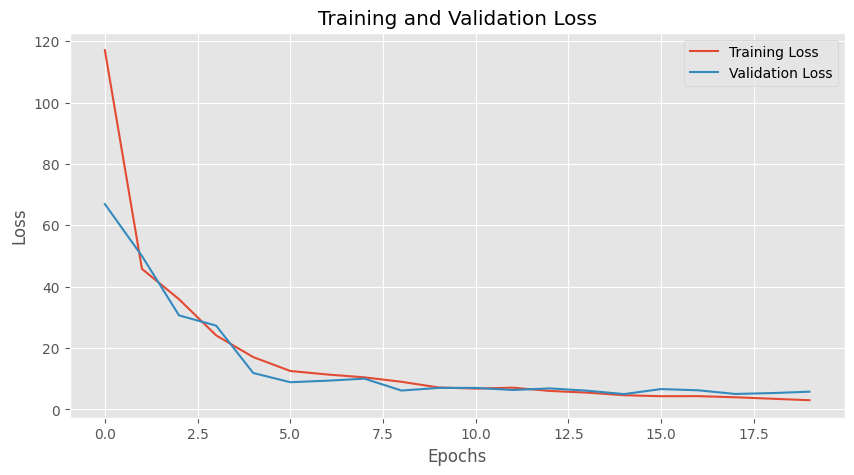

In [30]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(model_history['training_loss'], label='Training Loss')
plt.plot(model_history['validation_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('History.jpg', format='jpg', dpi=300)
plt.show()

# Test the model

In [28]:

def test_model(_model, _criterion, _test_loader, _device):
    _model.eval()
    test_loss = 0.0
    total_mse = 0.0

    with torch.no_grad():
        for imgs, kps in _test_loader:
            imgs = imgs.to(_device)
            kps = kps.to(_device)

            pred_kps = _model(imgs)
            loss = _criterion(pred_kps, kps)
            test_loss += loss.item()

            mse = torch.mean((pred_kps - kps) ** 2)
            total_mse += mse.item()

    avg_test_loss = test_loss / len(_test_loader)
    avg_mse = total_mse / len(_test_loader)

    print(f'Test Loss: {avg_test_loss}')
    print(f'Test MSE: {avg_mse}')


In [29]:
# Run the test
test_model(model, criterion, test_loader, device)

Test Loss: 2.768577068685049
Test MSE: 2.768577068685049


## Save model

In [21]:
torch.save(model.state_dict(), f'keypoint_model.pth')